## Метод $k$ ближайших соседей.

В этом ноутбуке мы посмотрим на пример применения метода kNN для искуственно сгенерированных данных на задаче классификации.

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style='dark', font_scale=1.7)

import warnings
warnings.filterwarnings('ignore')

### Генерация данных

Сгенерируем данные из двух двумерных гауссовских распределений с помощью функции `make_blobs`.

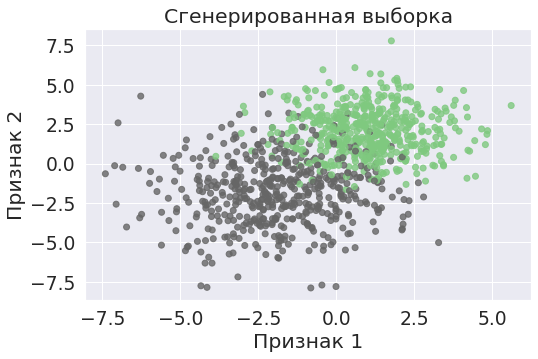

In [2]:
X, y = make_blobs(
    n_samples=(500, 500),  # количество точек в каждом кластере
    centers=[[1, 2], [-2, -2]],  # центры кластеров
    cluster_std=[1.5, 2],  # стандартные отклонения по кластерам
    random_state=42  # зерно случайности
)

plt.figure(figsize=(8, 5))
plt.title('Сгенерированная выборка')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, cmap='Accent')
plt.grid()
plt.xlabel('Признак 1'), plt.ylabel('Признак 2')
plt.show()

In [3]:
X.shape, y.shape

((1000, 2), (1000,))

### Применение метода

В `sklearn.neighbors` метод kNN представлен классами `KNeighborsClassifier` и `KNeighborsRegressor` для классификации и регрессии соответственно.

Оба метода имеют следующие параметры:
* `n_neighbors` &mdash; количество ближайших соседей, используемых для предсказания;
* `weights` &mdash; способ вычисления весов объектов из набора k ближайших соседей: 
    - `uniform` для одинакового веса для всех точек, 
    - `distance` для весов, пропорциональных обратному расстоянию;
* `metric` &mdash; метрика, по которой считаются ближайшие соседи;
* `p` &mdash; порядок расстояния Минковского между точками: $$\rho(x, y) = \left( \sum_{i=1}^d |x_i - y_i|^p \right)^{1/p};$$

Разделим на обучающую и тестовую выборки

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((850, 2), (150, 2), (850,), (150,))

Обучим метод трех ближайших соседей

In [5]:
model = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

Качество на тесте

In [6]:
print(f'accuracy: {accuracy_score(y_test, model.predict(X_test)) :.3}')
print(f'f1 score: {f1_score(y_test, model.predict(X_test)) :.3}')

accuracy: 0.92
f1 score: 0.898


### Визуализация

Визуализируем предсказания kNN для различных $k$. Для этого вычислим предсказания по сетке и нарисуем полученные классы.

In [7]:
def generate_grid(train_sample, border=1.0, step=0.05):
    '''
    Генерация сетки для вычисления предсказаний.
    
    :param train_sample: (np.ndarray)
        Точки выборки, по которым строилась модель
    :param border: (float)
        Отступ от максимальных и минимальных значений выборки по обеим координатам
    :param step: (float)
        Шаг сетки
    '''
    
    return np.meshgrid(
        np.arange(min(train_sample[:, 0]) - border, 
                  max(train_sample[:, 0]) + border, 
                  step),
        np.arange(min(train_sample[:, 1]) - border, 
                  max(train_sample[:, 1]) + border, 
                  step)
    )

In [8]:
def create_picture(X_train, y_train, model, border=1.0, 
                   step=0.05, figsize=(18, 5), 
                   cmap='winter', alpha=1):
    '''
    Визуализация предсказаний классов на плоскости и точек обучающей выборки.
    
    :param X_train:
        Точки обучающей выборки
    :param y_train:
        Классы точек обучающей выборки
    :param model:
        Модель-классификатор, для которой визуализируются предсказания
    '''
    
    # == Создание сетки ==
    grid = generate_grid(X_train, border, step)
    # Выворачивание сетки для приведения к форме выборки
    grid_ravel = np.c_[grid[0].ravel(), grid[1].ravel()]
    
    # == Предсказание значений для сетки == 
    # Берем вероятности для первого класса
    grid_predicted_ravel = model.predict_proba(grid_ravel)[:, 1]
    # Подгоняем размер
    grid_predicted = grid_predicted_ravel.reshape(grid[0].shape)
    
    
    # == Построение фигуры ==
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(grid[0], grid[1], grid_predicted > 0.5, cmap=cmap)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                alpha=alpha, cmap=cmap, edgecolor='black')
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    plt.title(u'Классификация {}-NN'.format(model.get_params()['n_neighbors']))
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(grid[0], grid[1], grid_predicted, cmap=cmap)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                alpha=alpha, cmap=cmap, edgecolor='black')
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    plt.title(u'Вероятности {}-NN'.format(model.get_params()['n_neighbors']))
    
    plt.show()

Сначала действуем в метрике $\ell_2$.

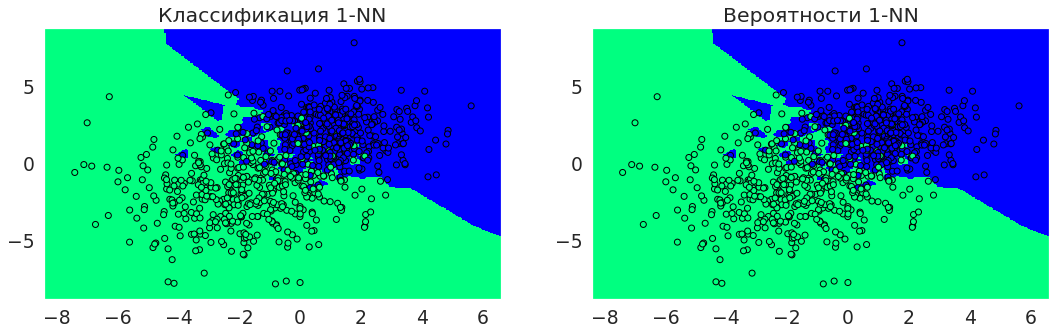

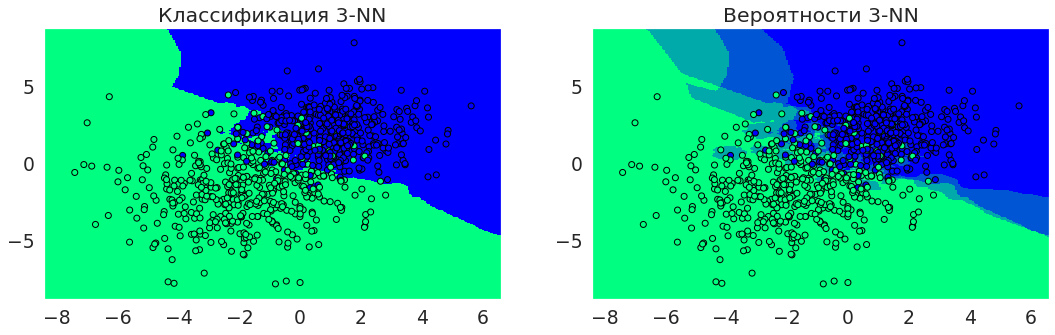

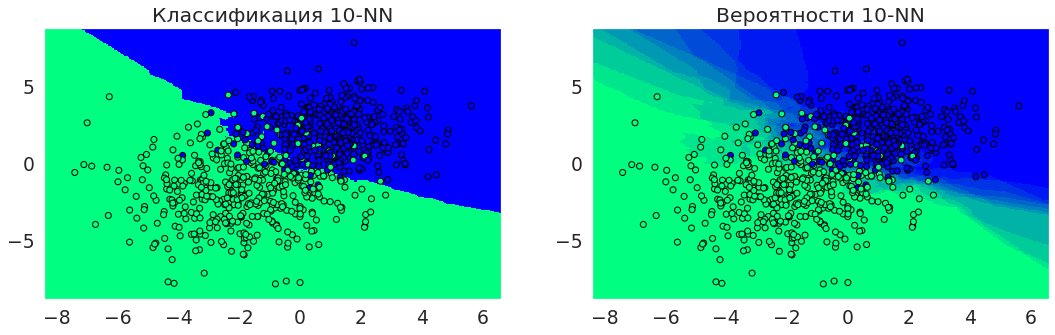

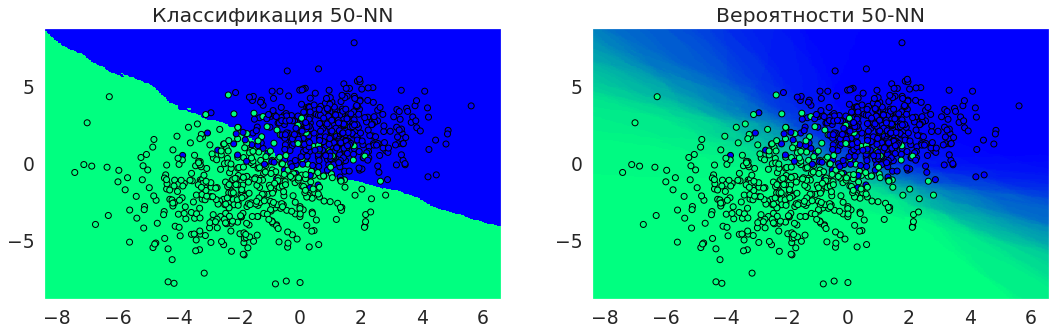

In [9]:
for n_neighbors in [1, 3, 10, 50]:
    create_picture(
        X_train, 
        y_train, 
        KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    )

Теперь построим аналогичные графики для метрики $\ell_1$.

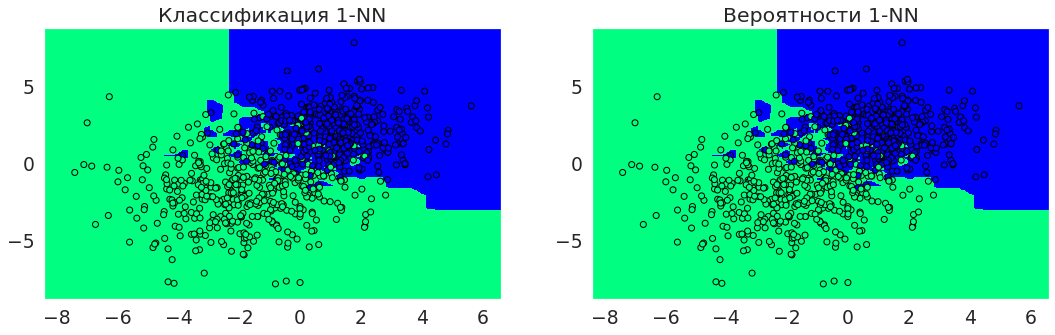

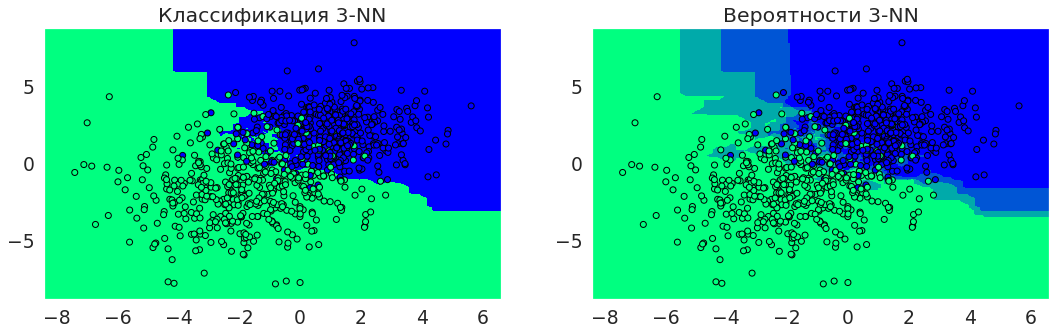

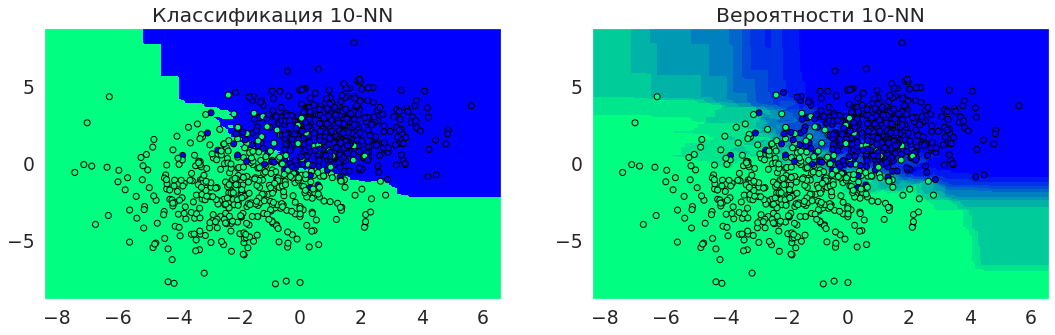

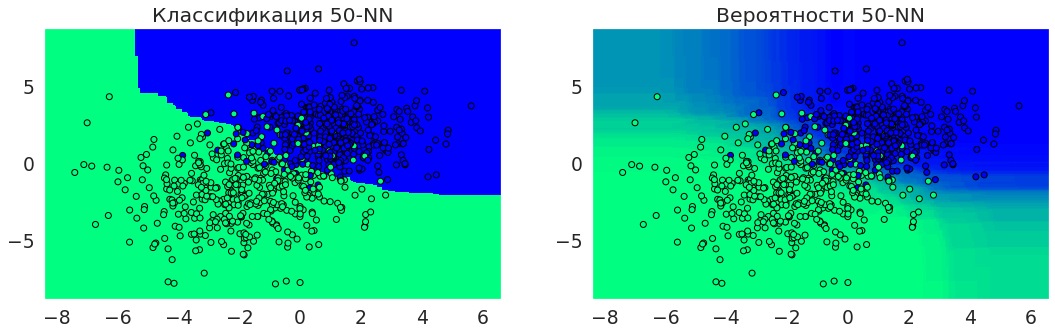

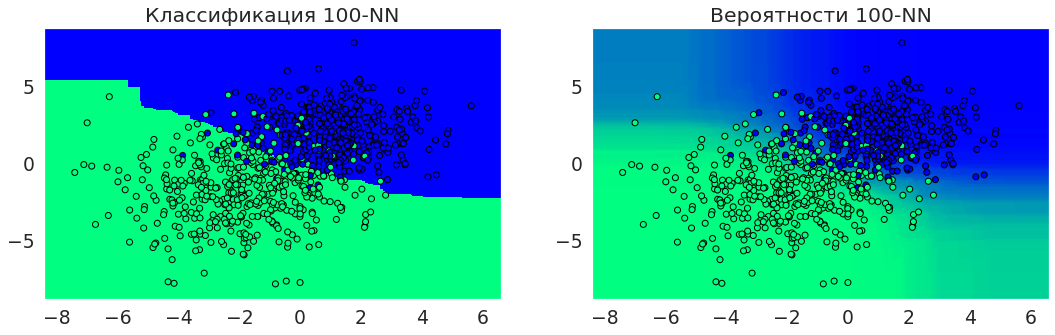

In [10]:
for n_neighbors in [1, 3, 10, 50, 100]:
    create_picture(
        X_train, 
        y_train, 
        KNeighborsClassifier(n_neighbors=n_neighbors, p=1).fit(X_train, y_train)
    )

**Вывод:**

При увеличении числа соседей разделяющая кривая получается более гладкой. При маленьком же числе рассматриваемых соседей модель чувствительна к наложению классов, из-за чего в предсказаниях разделяющая поверхность очень неровная. Также при большом числе классов переход между классами на графике вероятностей намного более плавный.